In [1]:
import torch.nn as nn
import torch
import torchvision.transforms as transforms
import torchvision
import time
import numpy as np
from sklearn.metrics import confusion_matrix
import pandas as pd
import os
import torchvision.models as models
import cv2
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix,accuracy_score,precision_score,recall_score,f1_score,ConfusionMatrixDisplay

In [2]:
img_size = (299, 299)
data = []
labels = []

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
from zipfile import *
file_name = "/content/drive/MyDrive/dataset_2_classes.zip" 
with ZipFile(file_name, 'r') as zip:
  zip.extractall()
  print('Done')

Done


In [3]:
def set_device():
    device= torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
    return device

In [4]:
device=set_device()

In [5]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [9]:
for class_folder in os.listdir('dataset_2_classes/train/'):
    class_folder_path = os.path.join('dataset_2_classes/train', class_folder)
    if os.path.isdir(class_folder_path):
        # Loop over each image file in the class folder
        for file_name in os.listdir(class_folder_path):
            if file_name.endswith('.JPG'):
                # Load the image and resize it to the desired size
                img = cv2.imread(os.path.join(class_folder_path, file_name))
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
                img= cv2.resize(img,img_size)

                # Add the image data and label to the lists
                data.append(img)
                labels.append(class_folder)

In [10]:
data=np.array(data)
labels=np.array(labels)
data_t=torch.from_numpy(data)

In [11]:
from sklearn.preprocessing import LabelEncoder
label_encoder = LabelEncoder()
classes=np.unique(labels)
labels=label_encoder.fit_transform(labels)
labels_t=torch.from_numpy(labels)

In [12]:
print(data_t.shape)
print(labels_t.shape)

torch.Size([600, 299, 299, 3])
torch.Size([600])


In [13]:
print(classes)

['train_healthy' 'train_unhealthy']


In [28]:
def get_model():
    model = models.inception_v3(pretrained=True)
    for param in model.parameters():
        param.requires_grad = False #Freezing all the layers and changing only the below layers
    model.avgpool = nn.AdaptiveAvgPool2d(output_size=(1,1))
    model.fc = nn.Sequential(nn.Flatten(),
                            nn.Linear(2048,128),
                            nn.ReLU(),
                            nn.Linear(128,2))
    model.aux_logits = False
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=1e-3,momentum=0.9)
    return model.to(device), loss_fn, optimizer

In [29]:
@torch.no_grad()
def accuracy(images, labels, model):
    model.eval()
    prediction = model(images)
    max_values, argmaxes = prediction.max(-1)
    is_correct = argmaxes == labels
    return is_correct.cpu().numpy().tolist()

In [30]:
def evaluate_model(model,test_loader):
    model.eval()
    predicted_correct =0
    total = 0
    with torch.no_grad():
        for data in test_loader:
            images,labels = data
            images = images.to(device)
            labels = labels.to(device)
            total+=labels.size(0)
            outputs = model(images)
            _,predicted = torch.max(outputs,1)
            predicted_correct += (predicted == labels).sum().item()
    epoch_accuracy = 100.0* predicted_correct/total
    print("Testing Data: Epoch Accuracy: %.3f"%(epoch_accuracy))
    return epoch_accuracy

In [31]:
model, loss_fn, optimizer = get_model()

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=Inception_V3_Weights.IMAGENET1K_V1`. You can also use `weights=Inception_V3_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/inception_v3_google-0cc3c7bd.pth" to /root/.cache/torch/hub/checkpoints/inception_v3_google-0cc3c7bd.pth
100%|██████████| 104M/104M [00:01<00:00, 65.5MB/s] 


In [32]:
from torch.utils.data import Dataset, DataLoader

In [33]:
data_transforms = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((img_size)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

In [34]:
class ImageDataset(Dataset):
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels

    def __getitem__(self, index):
        img = self.data[index]
        label = self.labels[index]
        img = torch.tensor(img, dtype=torch.float32)
        img = img.permute(2, 0, 1)  # change the image from HxWxC to CxHxW
        img = data_transforms(img)
        return img, label

    def __len__(self):
        return len(self.data)

In [35]:
def get_mean_std(loader):
    mean = 0.
    std = 0.
    total_images_count = 0
    for images,_ in loader:
        images_count_in_batch = images.size(0)
#         print(images.shape)
        images =images.view(images_count_in_batch,images.size(1),-1)
        mean+=images.mean(2).sum(0)
        std+=images.std(2).sum(0)
        total_images_count+=images_count_in_batch
    mean /= total_images_count
    std /= total_images_count
    return mean,std

In [36]:
def transform(dataset):
    data_transform = transforms.Compose([transforms.Resize((299,299)),transforms.ToTensor()])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=64,shuffle=True)
    mean,std=get_mean_std(data_loader)
    data_transform = transforms.Compose([
        transforms.Resize((299,299)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ToTensor(),
        transforms.Normalize(torch.Tensor(mean),torch.Tensor(std))
    ])
    data_set=torchvision.datasets.ImageFolder(root=dataset,transform=data_transform)
    data_loader=torch.utils.data.DataLoader(dataset=data_set,batch_size=64,shuffle=True,drop_last=False,num_workers=0)
    return data_loader

In [37]:
test_dataset='dataset_2_classes/test/'
test_loader=transform(test_dataset)

In [38]:
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=20, eta_min=0.0001)

In [39]:
from sklearn.model_selection import StratifiedKFold

In [40]:
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

Fold: 1 
Epoch: 1 


<ipython-input-34-890f75dd765d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.615, Epoch Accuracy: 66.667, Validation Loss: 0.485,Validation accuracy: 80.000
Epoch: 2 
Training Data: Epoch Loss: 0.482, Epoch Accuracy: 80.000, Validation Loss: 0.460,Validation accuracy: 80.000
Epoch: 3 
Training Data: Epoch Loss: 0.472, Epoch Accuracy: 80.000, Validation Loss: 0.450,Validation accuracy: 80.000
Epoch: 4 
Training Data: Epoch Loss: 0.453, Epoch Accuracy: 80.000, Validation Loss: 0.435,Validation accuracy: 80.000
Epoch: 5 
Training Data: Epoch Loss: 0.431, Epoch Accuracy: 80.000, Validation Loss: 0.416,Validation accuracy: 80.000
Epoch: 6 
Training Data: Epoch Loss: 0.424, Epoch Accuracy: 80.000, Validation Loss: 0.391,Validation accuracy: 80.000
Epoch: 7 
Training Data: Epoch Loss: 0.404, Epoch Accuracy: 80.000, Validation Loss: 0.370,Validation accuracy: 80.000
Epoch: 8 
Training Data: Epoch Loss: 0.387, Epoch Accuracy: 80.000, Validation Loss: 0.366,Validation accuracy: 80.000
Epoch: 9 
Training Data: Epoch Loss: 0.372, Epoch Accuracy

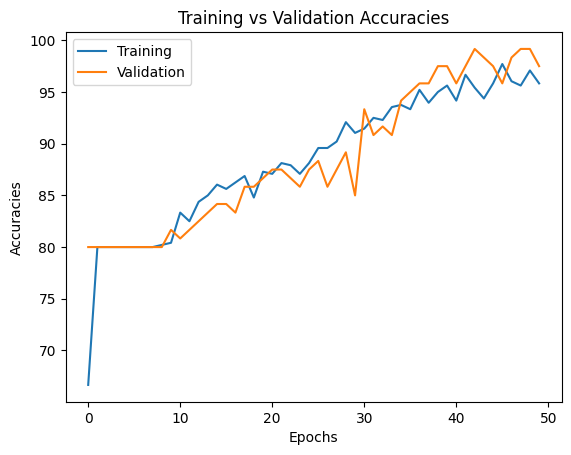

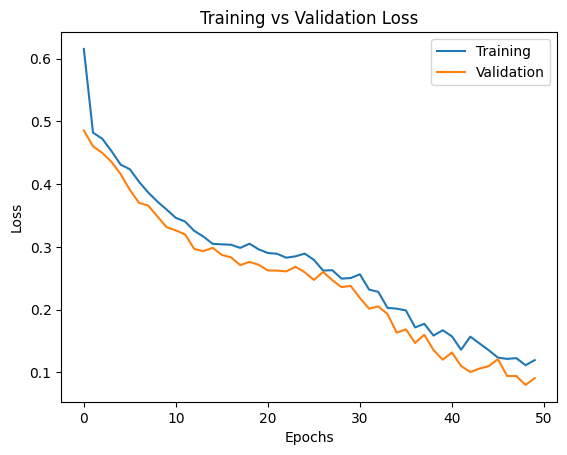

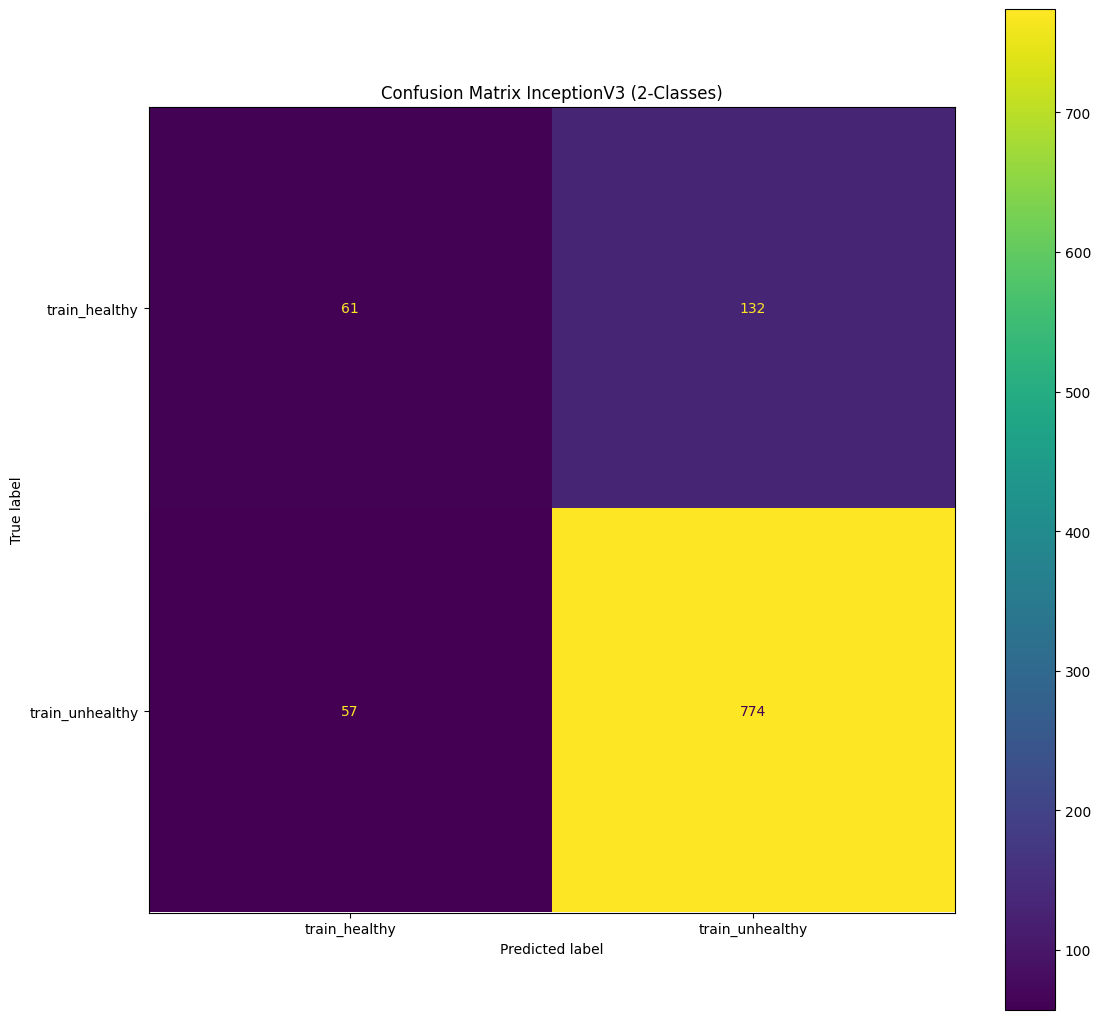

Precision Macro:0.69
Precision Micro:0.82
Recall Macro:0.62
Recall Micro:0.82
F1-Score Macro:0.64
F1-Score Micro:0.82
Fold: 2 
Epoch: 1 


<ipython-input-34-890f75dd765d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.118, Epoch Accuracy: 97.083, Validation Loss: 0.086,Validation accuracy: 99.167
Epoch: 2 
Training Data: Epoch Loss: 0.136, Epoch Accuracy: 95.000, Validation Loss: 0.086,Validation accuracy: 98.333
Epoch: 3 
Training Data: Epoch Loss: 0.128, Epoch Accuracy: 95.208, Validation Loss: 0.073,Validation accuracy: 98.333
Epoch: 4 
Training Data: Epoch Loss: 0.110, Epoch Accuracy: 97.917, Validation Loss: 0.075,Validation accuracy: 99.167
Epoch: 5 
Training Data: Epoch Loss: 0.124, Epoch Accuracy: 95.625, Validation Loss: 0.072,Validation accuracy: 100.000
Epoch: 6 
Training Data: Epoch Loss: 0.106, Epoch Accuracy: 96.875, Validation Loss: 0.077,Validation accuracy: 96.667
Epoch: 7 
Training Data: Epoch Loss: 0.094, Epoch Accuracy: 98.125, Validation Loss: 0.065,Validation accuracy: 100.000
Epoch: 8 
Training Data: Epoch Loss: 0.107, Epoch Accuracy: 96.250, Validation Loss: 0.080,Validation accuracy: 96.667
Epoch: 9 
Training Data: Epoch Loss: 0.111, Epoch Accura

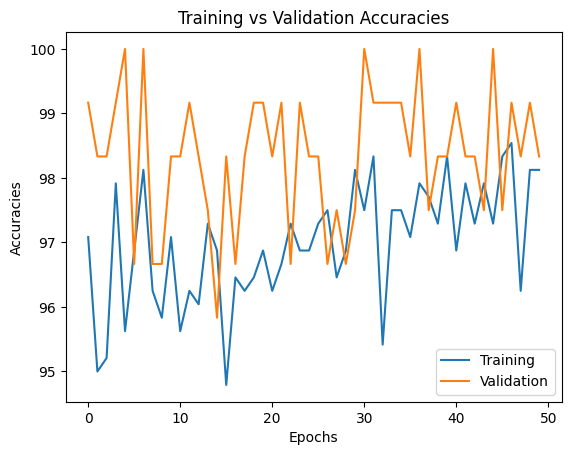

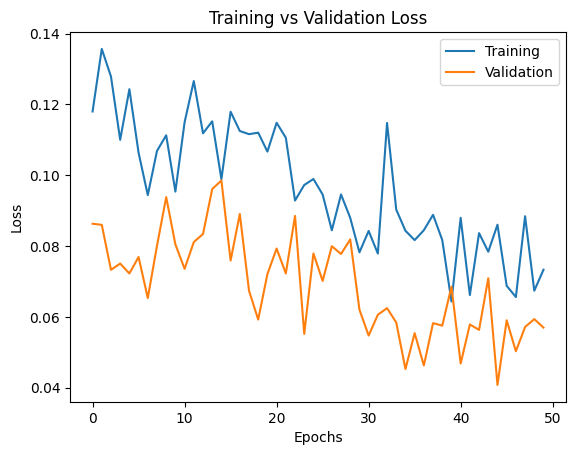

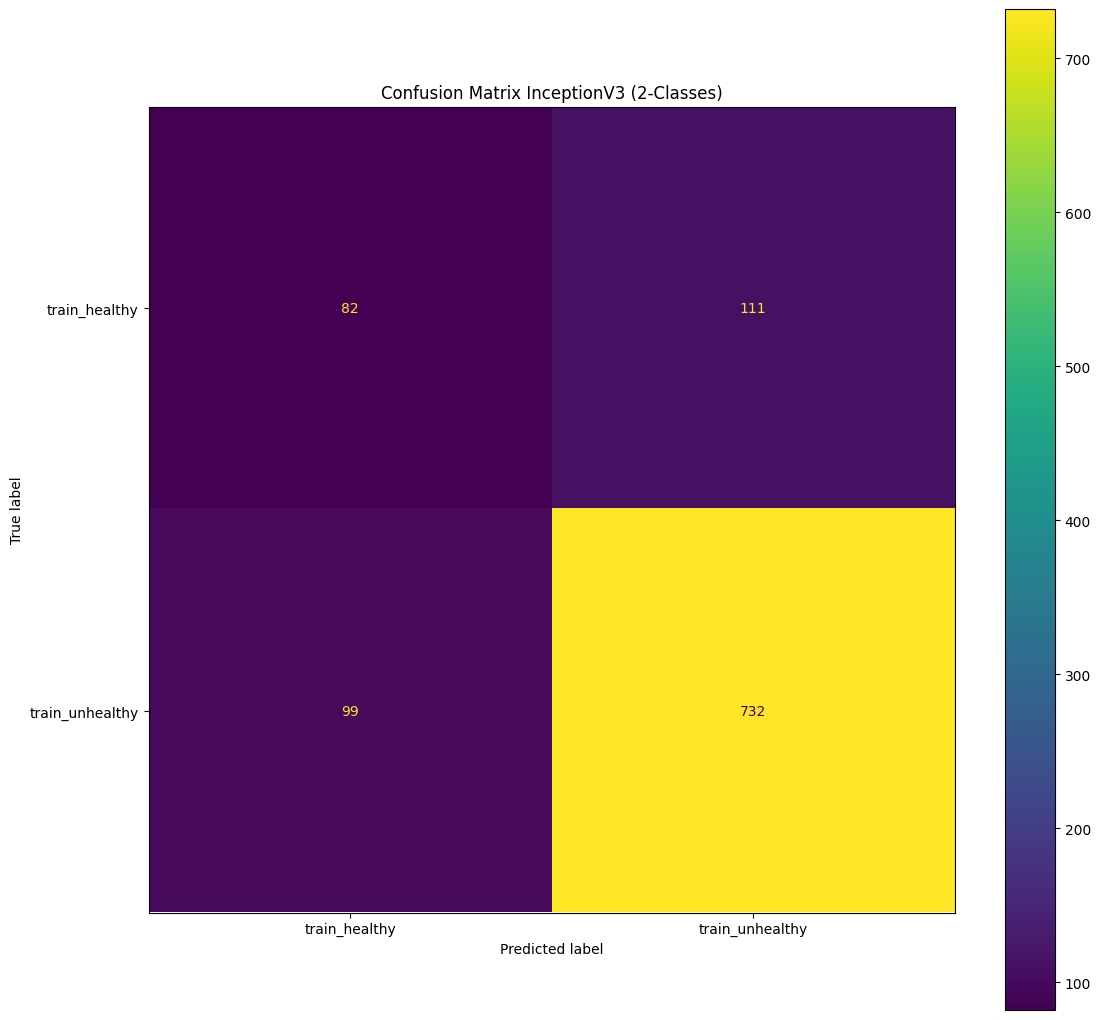

Precision Macro:0.66
Precision Micro:0.79
Recall Macro:0.65
Recall Micro:0.79
F1-Score Macro:0.66
F1-Score Micro:0.79
Fold: 3 
Epoch: 1 


<ipython-input-34-890f75dd765d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.069, Epoch Accuracy: 97.500, Validation Loss: 0.037,Validation accuracy: 99.167
Epoch: 2 
Training Data: Epoch Loss: 0.090, Epoch Accuracy: 97.083, Validation Loss: 0.041,Validation accuracy: 100.000
Epoch: 3 
Training Data: Epoch Loss: 0.068, Epoch Accuracy: 98.125, Validation Loss: 0.041,Validation accuracy: 100.000
Epoch: 4 
Training Data: Epoch Loss: 0.079, Epoch Accuracy: 97.500, Validation Loss: 0.041,Validation accuracy: 99.167
Epoch: 5 
Training Data: Epoch Loss: 0.060, Epoch Accuracy: 98.750, Validation Loss: 0.031,Validation accuracy: 100.000
Epoch: 6 
Training Data: Epoch Loss: 0.063, Epoch Accuracy: 98.333, Validation Loss: 0.052,Validation accuracy: 98.333
Epoch: 7 
Training Data: Epoch Loss: 0.075, Epoch Accuracy: 97.500, Validation Loss: 0.054,Validation accuracy: 98.333
Epoch: 8 
Training Data: Epoch Loss: 0.092, Epoch Accuracy: 96.667, Validation Loss: 0.037,Validation accuracy: 100.000
Epoch: 9 
Training Data: Epoch Loss: 0.076, Epoch Accu

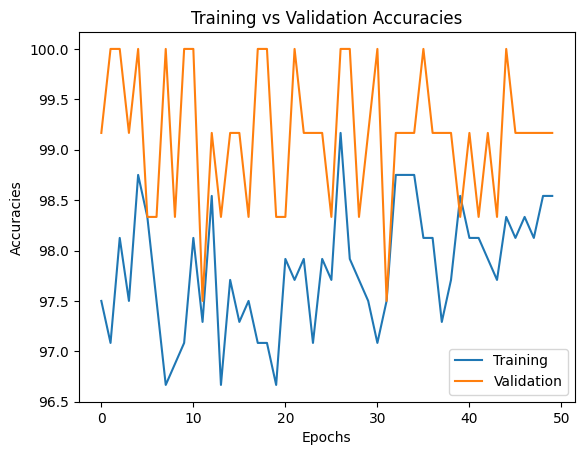

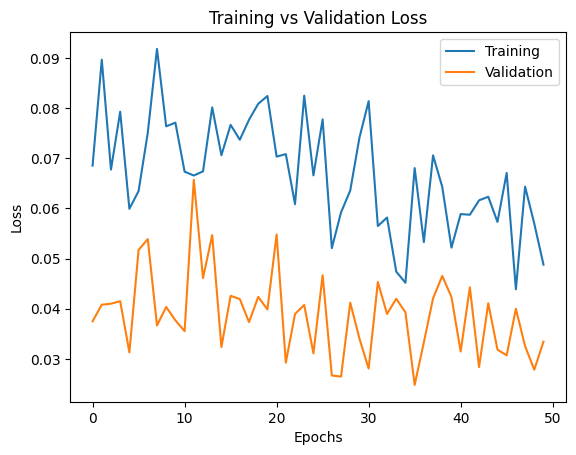

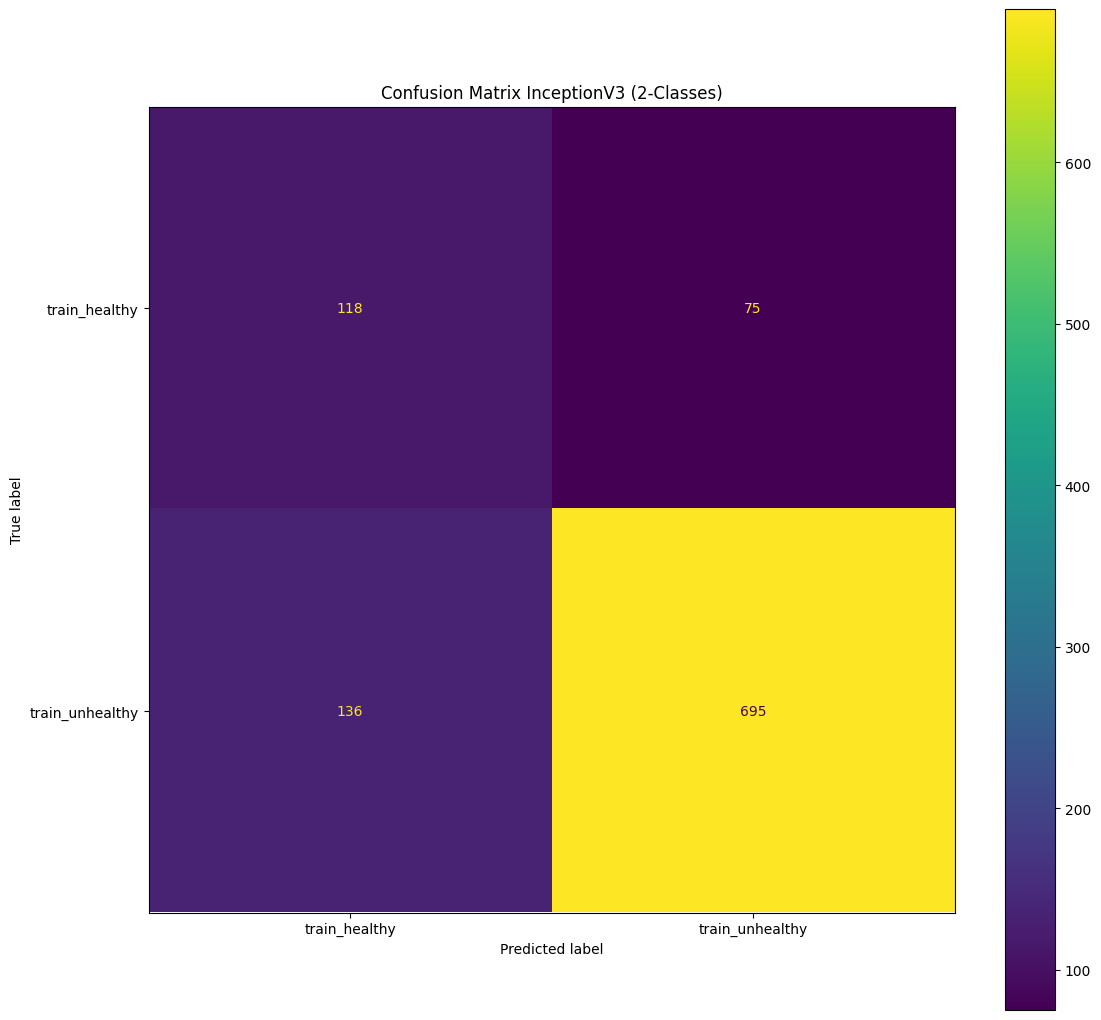

Precision Macro:0.68
Precision Micro:0.79
Recall Macro:0.72
Recall Micro:0.79
F1-Score Macro:0.70
F1-Score Micro:0.79
Fold: 4 
Epoch: 1 


<ipython-input-34-890f75dd765d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.055, Epoch Accuracy: 99.167, Validation Loss: 0.025,Validation accuracy: 100.000
Epoch: 2 
Training Data: Epoch Loss: 0.052, Epoch Accuracy: 98.542, Validation Loss: 0.035,Validation accuracy: 99.167
Epoch: 3 
Training Data: Epoch Loss: 0.051, Epoch Accuracy: 98.125, Validation Loss: 0.022,Validation accuracy: 100.000
Epoch: 4 
Training Data: Epoch Loss: 0.073, Epoch Accuracy: 97.292, Validation Loss: 0.031,Validation accuracy: 99.167
Epoch: 5 
Training Data: Epoch Loss: 0.079, Epoch Accuracy: 97.500, Validation Loss: 0.032,Validation accuracy: 99.167
Epoch: 6 
Training Data: Epoch Loss: 0.059, Epoch Accuracy: 97.917, Validation Loss: 0.039,Validation accuracy: 99.167
Epoch: 7 
Training Data: Epoch Loss: 0.050, Epoch Accuracy: 98.958, Validation Loss: 0.018,Validation accuracy: 100.000
Epoch: 8 
Training Data: Epoch Loss: 0.086, Epoch Accuracy: 96.667, Validation Loss: 0.032,Validation accuracy: 98.333
Epoch: 9 
Training Data: Epoch Loss: 0.053, Epoch Accur

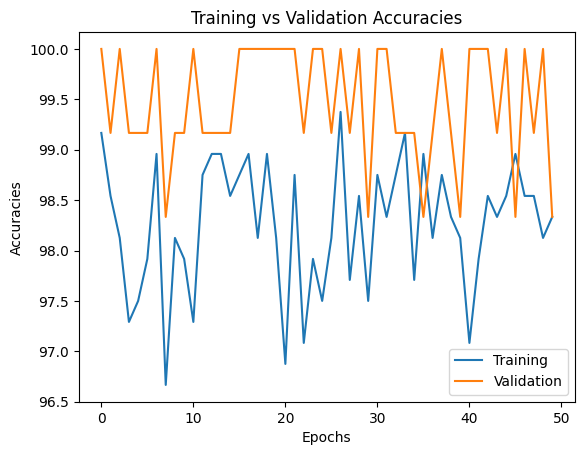

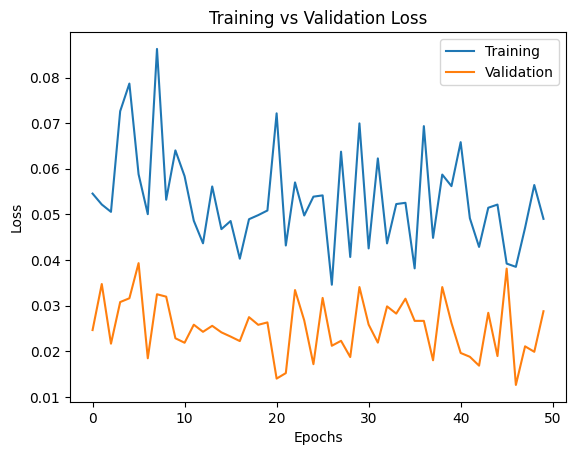

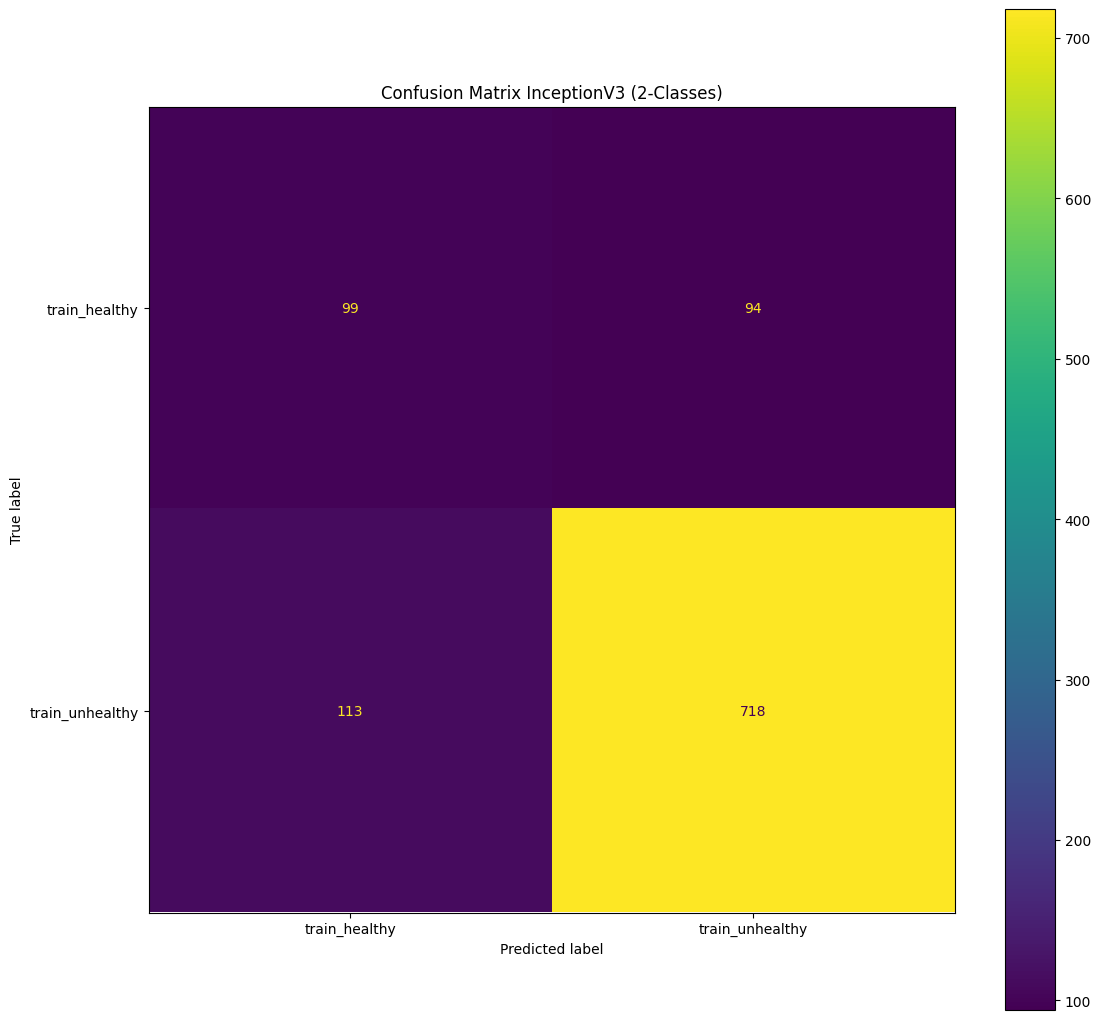

Precision Macro:0.68
Precision Micro:0.80
Recall Macro:0.69
Recall Micro:0.80
F1-Score Macro:0.68
F1-Score Micro:0.80
Fold: 5 
Epoch: 1 


<ipython-input-34-890f75dd765d>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  img = torch.tensor(img, dtype=torch.float32)


Training Data: Epoch Loss: 0.044, Epoch Accuracy: 98.750, Validation Loss: 0.015,Validation accuracy: 100.000
Epoch: 2 
Training Data: Epoch Loss: 0.045, Epoch Accuracy: 98.750, Validation Loss: 0.016,Validation accuracy: 100.000
Epoch: 3 
Training Data: Epoch Loss: 0.055, Epoch Accuracy: 98.542, Validation Loss: 0.014,Validation accuracy: 100.000
Epoch: 4 
Training Data: Epoch Loss: 0.056, Epoch Accuracy: 97.917, Validation Loss: 0.013,Validation accuracy: 100.000
Epoch: 5 
Training Data: Epoch Loss: 0.052, Epoch Accuracy: 98.125, Validation Loss: 0.011,Validation accuracy: 100.000
Epoch: 6 
Training Data: Epoch Loss: 0.068, Epoch Accuracy: 97.917, Validation Loss: 0.012,Validation accuracy: 100.000
Epoch: 7 
Training Data: Epoch Loss: 0.038, Epoch Accuracy: 98.542, Validation Loss: 0.017,Validation accuracy: 100.000
Epoch: 8 
Training Data: Epoch Loss: 0.081, Epoch Accuracy: 96.667, Validation Loss: 0.011,Validation accuracy: 100.000
Epoch: 9 
Training Data: Epoch Loss: 0.046, Epoch 

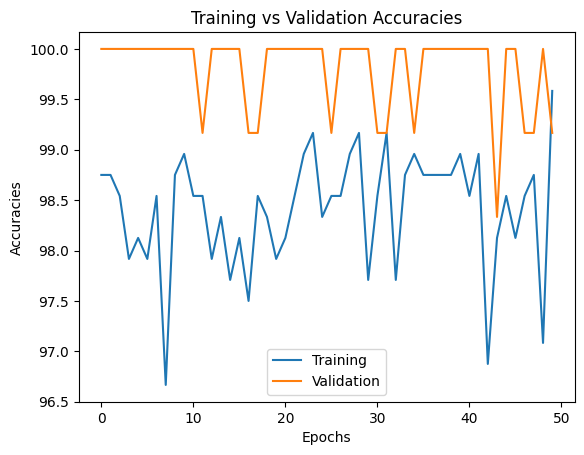

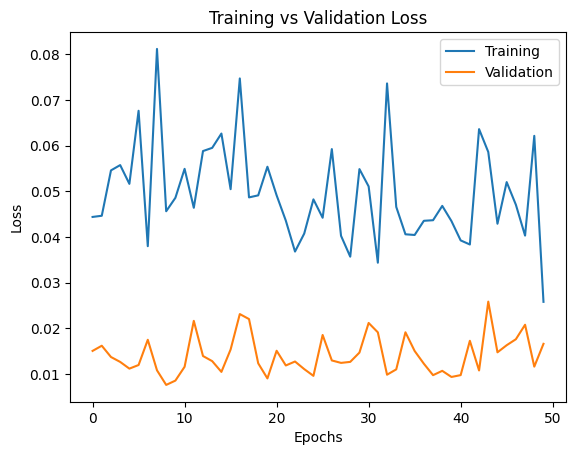

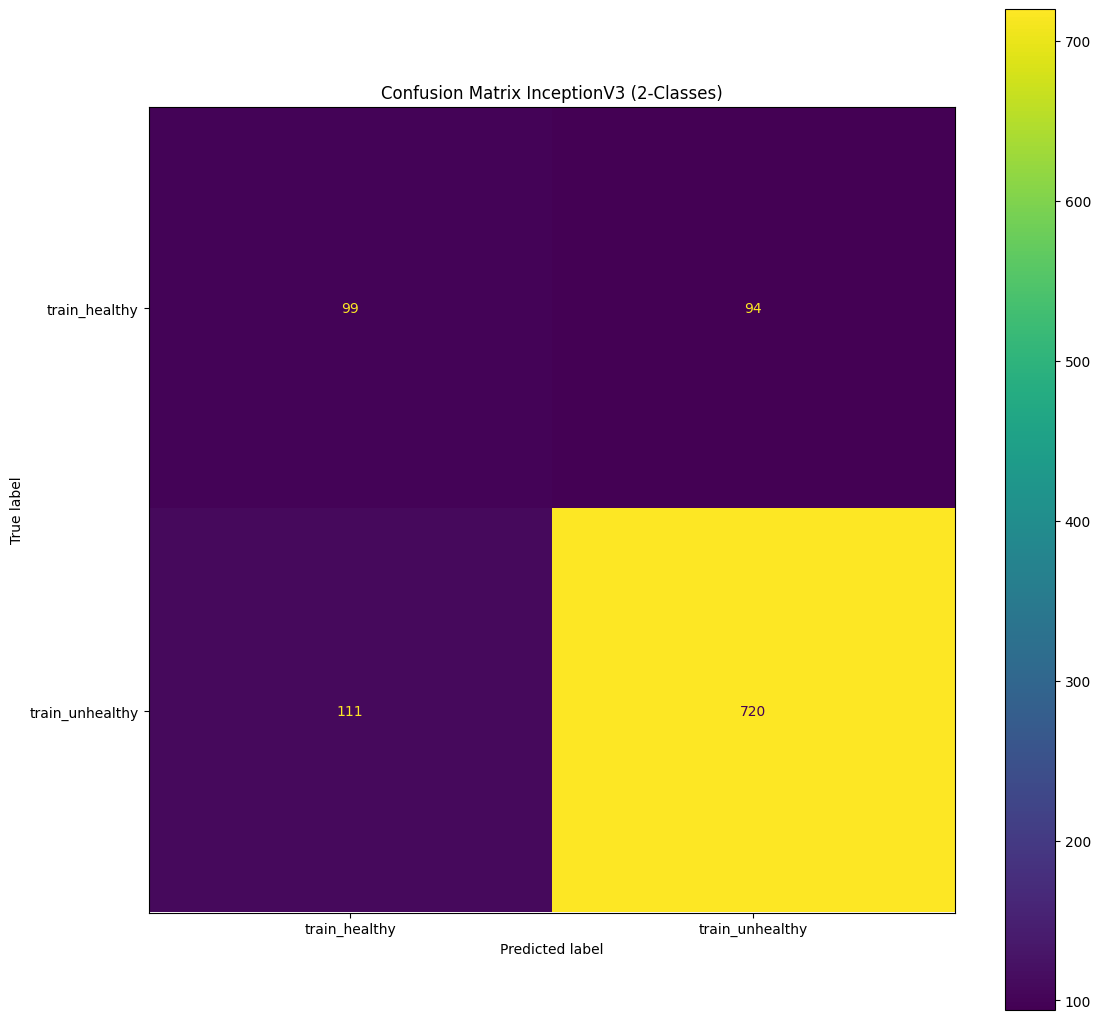

Precision Macro:0.68
Precision Micro:0.80
Recall Macro:0.69
Recall Micro:0.80
F1-Score Macro:0.68
F1-Score Micro:0.80


In [41]:
from statistics import mean
fold_train_accuracy=[]
fold_train_loss=[]
fold_val_accuracy=[]
fold_val_loss=[]
fold_test_accuracy=[]
fold_precision_score=[]
fold_recall_score=[]
fold_f1_score=[]
for fold, (train_indexes, val_indexes) in enumerate(kfold.split(data_t, labels_t)):
    print("Fold: %d "%(fold+1))
    t1 = time.time()
    
    train_data, train_labels = data_t[train_indexes], labels_t[train_indexes]
    val_data, val_labels = data_t[val_indexes], labels_t[val_indexes]

    train_dataset = ImageDataset(train_data, train_labels)
    val_dataset = ImageDataset(val_data, val_labels)

    train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)
    val_dataloader = DataLoader(val_dataset, batch_size=32)

    n_epochs = 50
    epoch_count = 0
    Accuracies = [] 
    valAccuracies = []
    valLoss = []
    trainLoss = []
    validation_accuracy = 0
    for epoch in range(n_epochs):
      print("Epoch: %d "%(epoch+1))
      model.train()
      running_loss=0.0
      running_correct=0.0
      val_loss=0.0
      total=0
      for i,data in enumerate(train_dataloader):
        images,labels=data
        images=images.to(device)
        labels=labels.to(device)
        total+=labels.size(0)
        optimizer.zero_grad()
        outputs=model(images)
        _,predicted=torch.max(outputs.data,1)
        loss=loss_fn(outputs,labels)
        loss.backward()
        optimizer.step()
        running_loss+=loss.item()
        running_correct+=(labels==predicted).sum().item()
        traning_accuracy=(running_correct/total)*100
    
      validation_accuracy=0
      model.eval()
      with torch.no_grad():
        val_correct=0
        val_total=0
        val_loss=0
        for data in val_dataloader:
            images,val_labels=data[0].to(device), data[1].to(device)
            images = images.to(device)
            val_labels = val_labels.to(device)
            outputs=model(images)
            loss_val=loss_fn(outputs,val_labels)
            val_loss+= loss_val.item()
            _,predicted=torch.max(outputs.data,1)
            val_correct+=(predicted == val_labels).sum().item()
            val_total+=val_labels.size(0)
        validation_accuracy = (val_correct / val_total) *100
    
      scheduler.step()
      epoch_loss=running_loss/len(train_dataloader)
      val_loss=val_loss/len(val_dataloader)
      epoch_accuracy=100.00* running_correct/total
      Accuracies.append(epoch_accuracy)
      valAccuracies.append(validation_accuracy)
      trainLoss.append(epoch_loss)
      valLoss.append(val_loss)

      print("Training Data: Epoch Loss: %.3f, Epoch Accuracy: %.3f, Validation Loss: %.3f,Validation accuracy: %.3f"%(epoch_loss,epoch_accuracy,val_loss,validation_accuracy))

    test_accuracy=evaluate_model(model,test_loader)

    print("---Training finished in {} seconds---".format(time.time()-t1))
    torch.save(model.state_dict(), "2-Class-Inceptionv3-"+str(fold)+"_"+str(epoch_count)+"-epoch.pt")

    dict = {'Training': Accuracies, 'Validation': valAccuracies} 
    dictLoss = {'Training': trainLoss,'Validation': valLoss}
    df = pd.DataFrame(dict)
    df2 = pd.DataFrame(dictLoss)
#     df.to_csv("/content/Accuracies"+str(fold)+"_"+str(epoch)+".csv")
#     df2.to_csv("/content/Loss"+str(fold)+"_"+str(epoch)+".csv")

    fold_train_accuracy.append(mean(Accuracies))
    fold_train_loss.append(mean(trainLoss))
    fold_val_accuracy.append(mean(valAccuracies))
    fold_val_loss.append(mean(valLoss))
    fold_test_accuracy.append(test_accuracy)

    plt.plot(range(n_epochs),Accuracies, label="Training")
    plt.plot(range(n_epochs),valAccuracies, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracies")
    plt.title("Training vs Validation Accuracies")
    plt.legend()
    plt.show()

    plt.plot(range(n_epochs),trainLoss, label="Training")
    plt.plot(range(n_epochs),valLoss, label="Validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training vs Validation Loss")
    plt.legend()
    plt.show()

    y_pred = []
    y_true = []

    for image_data in test_loader:
        images,targets = image_data[0].to(device), image_data[1].to(device)
        output = model(images) 
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) 
        targets = targets.data.cpu().numpy()
        y_true.extend(targets)

    
    confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix(y_true, y_pred),display_labels=classes)
    fig,ax = plt.subplots()
    fig.set_size_inches(13,13)
    plt.title("Confusion Matrix InceptionV3 (2-Classes)")
    disp.plot(ax=ax)
    plt.show()  

    fold_precision_score.append(precision_score(y_true, y_pred, average='macro'))
    fold_recall_score.append(recall_score(y_true,y_pred,average='macro'))
    fold_f1_score.append(f1_score(y_true,y_pred,average='macro'))

    print("Precision Macro:{:.2f}".format(precision_score(y_true, y_pred, average='macro')))
    print("Precision Micro:{:.2f}".format(precision_score(y_true,y_pred,average='micro')))
    print("Recall Macro:{:.2f}".format(recall_score(y_true,y_pred,average='macro')))
    print("Recall Micro:{:.2f}".format(recall_score(y_true,y_pred,average='micro')))
    print("F1-Score Macro:{:.2f}".format(f1_score(y_true,y_pred,average='macro')))
    print("F1-Score Micro:{:.2f}".format(f1_score(y_true,y_pred,average='micro')))

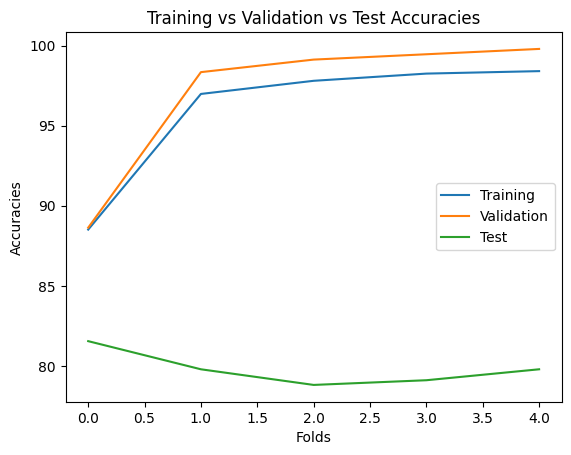

In [44]:
plt.plot(range(5),fold_train_accuracy, label="Training")
plt.plot(range(5),fold_val_accuracy, label="Validation")
plt.plot(range(5),fold_test_accuracy, label="Test")
plt.xlabel("Folds")
plt.ylabel("Accuracies")
plt.title("Training vs Validation vs Test Accuracies")
plt.legend()
plt.show()

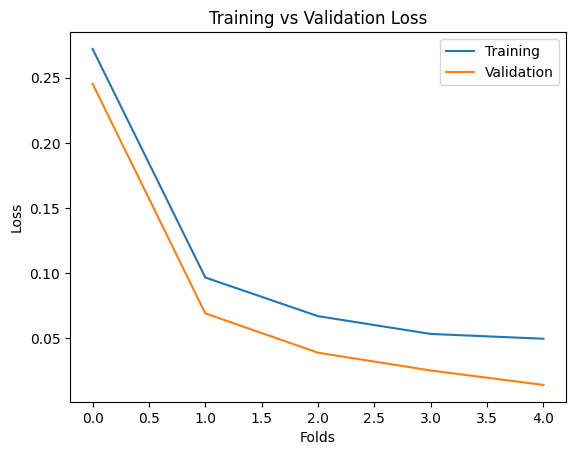

In [45]:
plt.plot(range(5),fold_train_loss, label="Training")
plt.plot(range(5),fold_val_loss, label="Validation")
plt.xlabel("Folds")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.show()

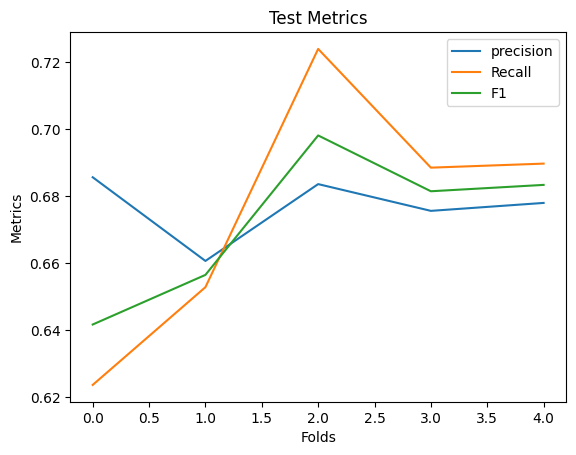

In [46]:
plt.plot(range(5),fold_precision_score, label="precision")
plt.plot(range(5),fold_recall_score, label="Recall")
plt.plot(range(5),fold_f1_score, label="F1")
plt.xlabel("Folds")
plt.ylabel("Metrics")
plt.title("Test Metrics")
plt.legend()
plt.show()